# Shatsky Rise

Reconstruct the subduction of the Shatsky Rise and the onset of flat subduction of the Farallon plate underneath North America.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import gplately
from slabdip import SlabDipper
import cartopy.crs as ccrs
from scipy.spatial import cKDTree
import stripy
import netCDF4

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# Call GPlately's DataServer object and download the plate model
gdownload = gplately.download.DataServer("Clennett2020")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

# Use the PlateReconstruction object to create a plate motion model
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Set time to present day for plotting
time = 0

# Call the PlotTopologies object
gplot = gplately.PlotTopologies(model, time, coastlines, continents, COBs)

Checking whether the requested files need to be updated...
Requested files are up-to-date!
Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [3]:
# grid directory
grid_dir = "/Users/ben/Dropbox/USyd/GPlates/"
agegrid_filename = grid_dir+"slab_dip/Clennet_AgeGrids_0.1d_masked/seafloor_age_mask_{:.1f}Ma.nc"
spreadrate_filename = grid_dir+"SampleData/Rasters/spreadrate_grids/rategrid_final_mask_{:.0f}.nc"
LIP_filename = grid_dir+"slab_dip/LIP_grids_only/reconstructedLIPs_{:.1f}Ma.nc"

# read in condensed kimberlite data
df_kimberlite = pd.read_excel("data/kimberlites_condensed.xlsx")
df_kimberlite = df_kimberlite[df_kimberlite['Age estimated RDM'] <= 170]
kimberlite_age = df_kimberlite['Age estimated RDM'].to_numpy()
extent_globe = [-180,180,-90,90]

kimb = gplately.Points(model, df_kimberlite['Longitude'], df_kimberlite['Latitude'])

# read in plate kinematics
df = pd.read_csv("data/subduction_data.csv")

# read in approximate trench locations
df_trench = pd.read_csv("data/trench_locations.csv")

In [4]:
# mask kimberlites based on plate ID
mask_america_kimb = np.logical_or(kimb.plate_id == 101, kimb.plate_id == 102)
mask_africa_kimb = np.logical_and(kimb.plate_id >= 701, kimb.plate_id <= 750)

By default, `SlabDipper` trains the neural network on the plate kinematics and rheology parameters from the previous set of notebooks to predict slab dip. These data are bundled with the `slabdip` package.

In [5]:
df = pd.read_csv("data/subduction_data.csv", index_col=0)

# remove NaN entries
df = df[np.isfinite(df['slab_dip'])]

variable_names = ['angle', 'total_vel', 'vel', 'trench_vel', 'vratio', 'slab_age', 'slab_thickness',
                  'spreading_rate', 'density']

df_X_train = df[variable_names]
df_y_train =  df['slab_dip']

In [6]:
kn = KNeighborsRegressor(n_neighbors=3)

dipper = SlabDipper(sklearn_regressor=kn, X=df_X_train, y=df_y_train)
dipper.model = model
dipper.set_age_grid_filename(agegrid_filename)
dipper.set_spreading_rate_grid_filename(spreadrate_filename)
dipper.get_score()

0.9245808656536854

## Map arrival of Shatsky Rise


In [8]:
def read_LIP_height(reconstruction_time):
    # read in LIP (no LIPs beyond 153 Ma)
    if reconstruction_time <= 153:
        with netCDF4.Dataset(LIP_filename.format((reconstruction_time))) as nc:
            LIP_height = gplately.Raster(array=np.flipud(nc['height'][:]), extent=extent_globe)
    else:
        # create an array of zeros
        zero_data = np.zeros((181,91))
        LIP_height = gplately.Raster(array=np.ma.array(zero_data,
                                      mask=np.ones_like(zero_data,dtype=bool)),
                            extent=extent_globe)

    LIP_height.data.data[LIP_height.data.mask] = 0
    return LIP_height

Completed 110 Ma
Completed 105 Ma
Completed 100 Ma
Completed 95 Ma
Completed 90 Ma
Completed 85 Ma
Completed 80 Ma
Completed 75 Ma
Completed 70 Ma
Completed 65 Ma
Completed 60 Ma
Completed 55 Ma
Completed 50 Ma


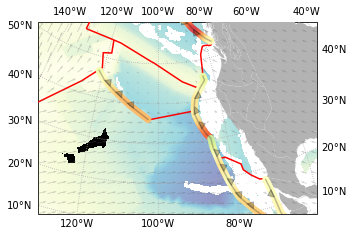

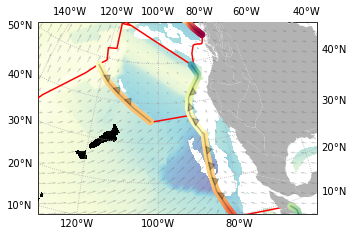

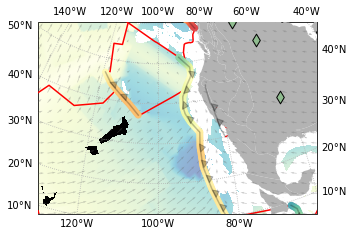

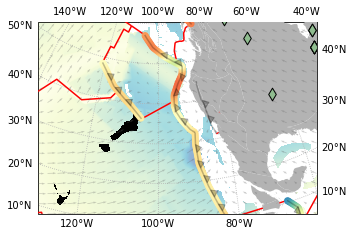

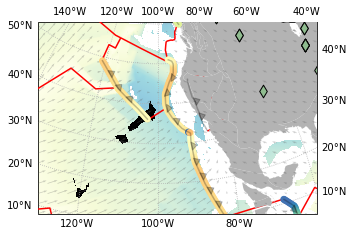

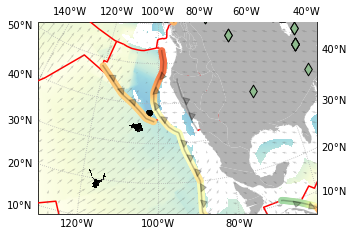

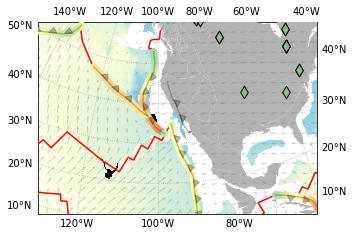

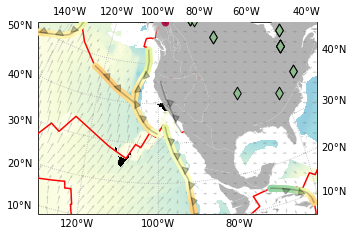

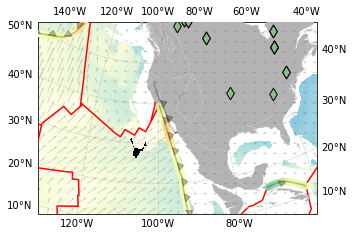

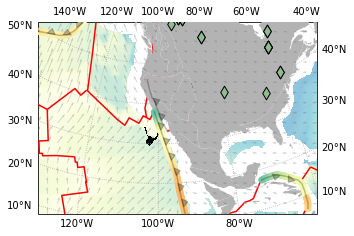

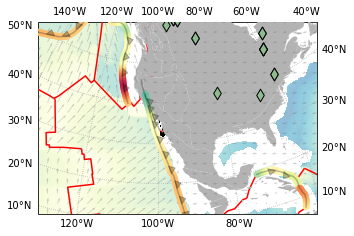

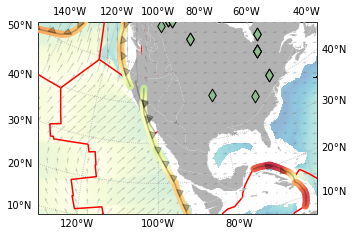

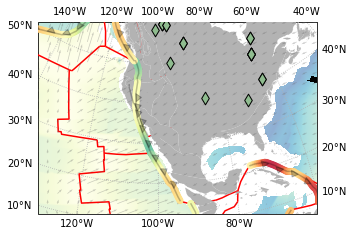

In [8]:
for time in range(110,45,-5):

    gplot.time = time
    age_grid = gplately.Raster(filename=agegrid_filename.format(gplot.time))
    LIP_height = read_LIP_height(gplot.time)
    df_time = dipper.tessellate_slab_dip(gplot.time)
    
    # apply Gaussian smoothing along subduction segments
    df_time['slab_dip'] = dipper.smooth_along_segments(df_time, 'slab_dip', smoothing=5)


    proj = ccrs.LambertAzimuthalEqualArea(-100, 40)

    fig = plt.figure(figsize=(5,5))
    ax = plt.axes(projection=proj)
    ax.set_extent([-130,-60,10,55])

    im = ax.imshow(age_grid.data, extent=extent_globe, cmap='YlGnBu', origin='lower', alpha=0.5,
                   vmin=0, vmax=160, transform=ccrs.PlateCarree(), rasterized=True, zorder=1)

    ax.imshow(LIP_height.data, extent=extent_globe, cmap='Greys', origin='lower',
                     vmin=0, vmax=1, transform=ccrs.PlateCarree(), rasterized=True, zorder=2)

    gplot.plot_ridges_and_transforms(ax, color='r', zorder=3)
    gplot.plot_misc_boundaries(ax, color='r', zorder=3)
    gplot.plot_plate_motion_vectors(ax, color='0.4', alpha=0.33, zorder=7, regrid_shape=20)
    gplot.plot_coastlines(ax, facecolor='0.7', edgecolor='none', zorder=3)
    
    sc0 = ax.scatter(df_time['lon'], df_time['lat'], c=df_time['slab_dip'], cmap='Spectral', vmin=10, vmax=60,
                     transform=ccrs.PlateCarree(), rasterized=True, zorder=8)


    gplot.plot_trenches(ax, zorder=9, alpha=0.25)
    gplot.plot_subduction_teeth(ax, zorder=9, alpha=0.25)
    ax.gridlines(draw_labels=True, linestyle=':')


    kimberlite_lon, kimberlite_lat = kimb.reconstruct(gplot.time)
    mask_kimberlites = kimberlite_age >= gplot.time

    sc1 = ax.scatter(kimberlite_lon[np.logical_and(mask_africa_kimb, mask_kimberlites)],
                     kimberlite_lat[np.logical_and(mask_africa_kimb, mask_kimberlites)],
                     color='LightSalmon', edgecolor='k', marker='d', s=80, transform=ccrs.PlateCarree(), zorder=10)

    sc2 = ax.scatter(kimberlite_lon[np.logical_and(mask_america_kimb, mask_kimberlites)],
                     kimberlite_lat[np.logical_and(mask_america_kimb, mask_kimberlites)],
                     color='DarkSeaGreen', edgecolor='k', marker='d', s=80, transform=ccrs.PlateCarree(), zorder=10)
    
    fig.savefig("shatsky_rise_{:04d}Ma.pdf".format(int(gplot.time)), bbox_inches='tight', dpi=300)
    print("Completed {} Ma".format(time))

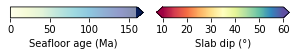

In [9]:
fig, (cax1, cax2) = plt.subplots(1,2, figsize=(5,0.2))
fig.subplots_adjust(wspace=0.1, hspace=0.05) # wspace=0.6

fig.colorbar(sc0, cax=cax2, orientation='horizontal', label='Slab dip (°)', extend='both', ticks=np.arange(10,70,10))
fig.colorbar(im,  cax=cax1, orientation='horizontal', label='Seafloor age (Ma)', extend='max')

fig.savefig("age_dip_colourbars.pdf", dpi=300, bbox_inches='tight')

## Map the slab dip globally

Include a little bit of smoothing for visual clarity.

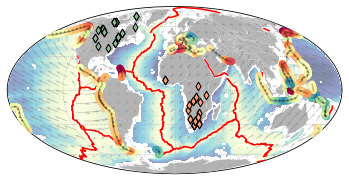

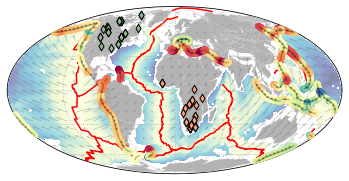

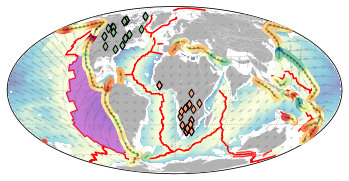

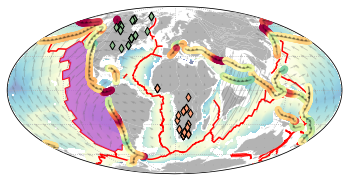

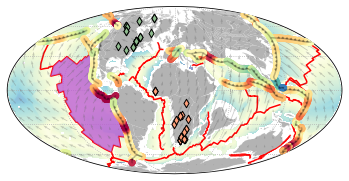

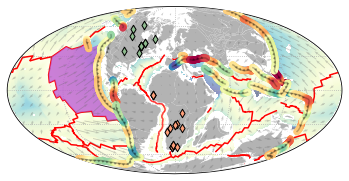

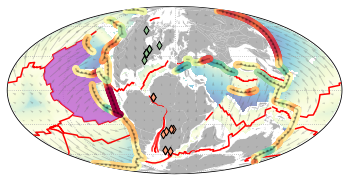

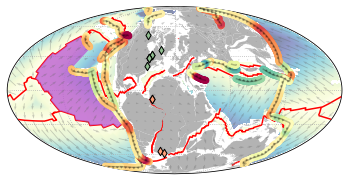

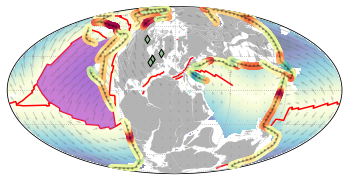

In [17]:
for time in range(0, 180, 20):
    gplot.time = time
    age_grid = gplately.Raster(filename=agegrid_filename.format(gplot.time))
#     LIP_height = read_LIP_height(gplot.time)
    df_time = dipper.tessellate_slab_dip(gplot.time)
    
    # apply Gaussian smoothing along subduction segments
    df_time['slab_dip'] = dipper.smooth_along_segments(df_time, 'slab_dip', smoothing=5)


    proj = ccrs.Mollweide(central_longitude=0)

    fig = plt.figure(figsize=(6,4))
    ax = plt.axes(projection=proj)

    im = ax.imshow(age_grid.data, extent=extent_globe, cmap='YlGnBu', origin='lower', alpha=0.5,
                   vmin=0, vmax=160, transform=ccrs.PlateCarree(), rasterized=True, zorder=1)

#     ax.imshow(LIP_height.data, extent=extent_globe, cmap='Greys', origin='lower',
#                      vmin=0, vmax=1, transform=ccrs.PlateCarree(), rasterized=True, zorder=2)

    gplot.plot_ridges_and_transforms(ax, color='r', zorder=3)
    # gplot.plot_misc_boundaries(ax, color='r', zorder=3)
    gplot.plot_plate_motion_vectors(ax, color='0.4', alpha=0.33, zorder=7, regrid_shape=20)
    gplot.plot_coastlines(ax, facecolor='0.7', edgecolor='none', zorder=3)
    gplot.plot_plate_id(ax, 902, facecolor='#BA55D3', edgecolor='none', zorder=4, alpha=0.75) # Farallon plate

    sc0 = ax.scatter(df_time['lon'], df_time['lat'], c=df_time['slab_dip'], cmap='Spectral', vmin=10, vmax=60,
                     transform=ccrs.PlateCarree(), rasterized=True, zorder=8)


    gplot.plot_trenches(ax, zorder=9, alpha=0.25)
    gplot.plot_subduction_teeth(ax, zorder=9, alpha=0.25)
    ax.gridlines(draw_labels=False, linestyle=':')


    kimberlite_lon, kimberlite_lat = kimb.reconstruct(gplot.time)
    mask_kimberlites = kimberlite_age >= gplot.time

    sc1 = ax.scatter(kimberlite_lon[np.logical_and(mask_africa_kimb, mask_kimberlites)],
                     kimberlite_lat[np.logical_and(mask_africa_kimb, mask_kimberlites)],
                     color='LightSalmon', edgecolor='k', marker='d', transform=ccrs.PlateCarree(), zorder=10)

    sc2 = ax.scatter(kimberlite_lon[np.logical_and(mask_america_kimb, mask_kimberlites)],
                     kimberlite_lat[np.logical_and(mask_america_kimb, mask_kimberlites)],
                     color='DarkSeaGreen', edgecolor='k', marker='d', transform=ccrs.PlateCarree(), zorder=10)

    fig.savefig("timeseries_{:04d}Ma.pdf".format(int(gplot.time)), bbox_inches='tight', dpi=300)
    
    